[INFO] Loading images ...
['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
[INFO] Processing no_tumor ...
[INFO] Processing pituitary_tumor ...
[INFO] Processing meningioma_tumor ...
[INFO] Processing glioma_tumor ...
[INFO] Image loading completed
[2 2 2 ... 0 0 0]
[INFO] Spliting data to train, test and validation set...
Image size: 72 X 72
Patch size: 5 X 5
Patches per image: 196
Elements per patch: 75
Epoch 1/5
6/6 [==============================] - 176s 24s/step - loss: 17.1344 - accuracy: 0.2361 - top-5-accuracy: 1.0000 - val_loss: 4.2969 - val_accuracy: 0.2566 - val_top-5-accuracy: 1.0000
Epoch 2/5
6/6 [==============================] - 124s 20s/step - loss: 5.9753 - accuracy: 0.2559 - top-5-accuracy: 1.0000 - val_loss: 1.9936 - val_accuracy: 0.2368 - val_top-5-accuracy: 1.0000
Epoch 3/5
6/6 [==============================] - 124s 20s/step - loss: 2.5127 - accuracy: 0.2412 - top-5-accuracy: 1.0000 - val_loss: 1.6596 - val_accuracy: 0.2368 - val_top-5-accuracy:

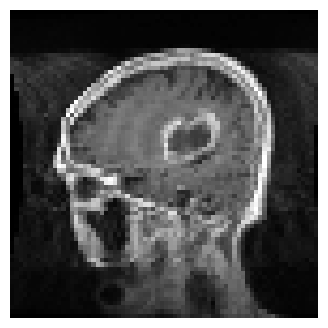

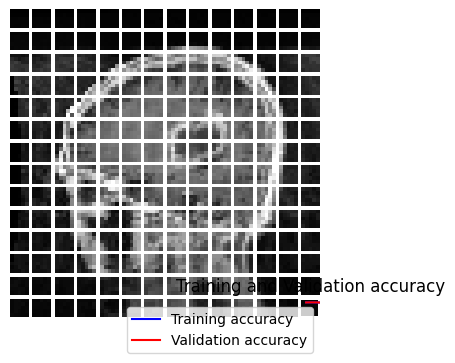

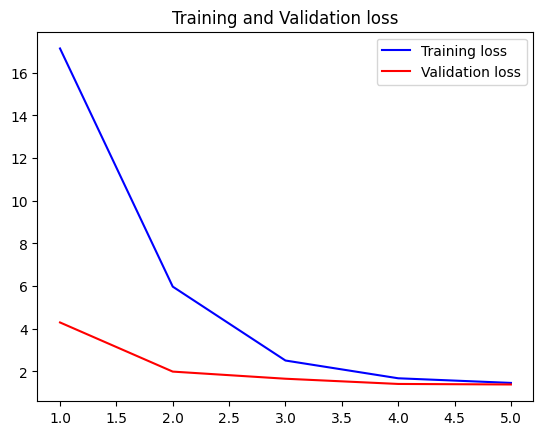

In [16]:
from datetime import datetime 

current_time = datetime.now()

import numpy as np
import pickle
import cv2
import sklearn
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Install TensorFlow Addons
# !pip install -U tensorflow-addons

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 300
image_size = 72  # We'll resize input images to this size
patch_size = 5  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

INIT_LR = 1e-3
BS = 32
default_image_size = tuple((72, 72))
image_size = 72
directory_root = '../input/brain-tumor-classification-mri/Training'
width = 256
height = 256
depth = 3

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        
        if image is not None :
            image = cv2.resize(image, default_image_size) 
            image = cv2.convertScaleAbs(image, alpha=1.2, beta=0)
            return image.astype(np.uint8)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    brain_folder_list = listdir(f"{directory_root}/")
    print(brain_folder_list)
    for brain_folder in brain_folder_list:
        print(f"[INFO] Processing {brain_folder} ...")
        brain_image_list = listdir(f"{directory_root}/{brain_folder}/")

        for image in brain_image_list[:500]:
            image_directory = f"{directory_root}/{brain_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(brain_folder) 
                exit
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

np_image_list = np.array(image_list, dtype=np.uint8) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(label_list)
print(y)
label_list = y.reshape(len(image_list), 1)

print("[INFO] Spliting data to train, test and validation set...")

x_train, x_test, y_train, y_test = train_test_split(
    np_image_list, label_list, test_size=0.2, random_state=42
)

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

class MaskedAutoencoder(keras.Model):
    def __init__(self, input_shape, latent_dim):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
                        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])

        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(input_shape[0] // 4 * input_shape[1] // 4 * 64, activation='relu'),
            layers.Reshape((input_shape[0] // 4, input_shape[1] // 4, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

input_shape = (72, 72, 3)

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    # Augment data.
    augmented = data_augmentation(inputs)

    # Add the Masked Autoencoder layer
    masked_autoencoder = MaskedAutoencoder(input_shape, 512)
    mae_output = masked_autoencoder(augmented)
    
    # Create patches.
    patches = Patches(patch_size)(mae_output)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

num_classes = 4

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

start_time = datetime.now()
time_elapsed = datetime.now() - start_time

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


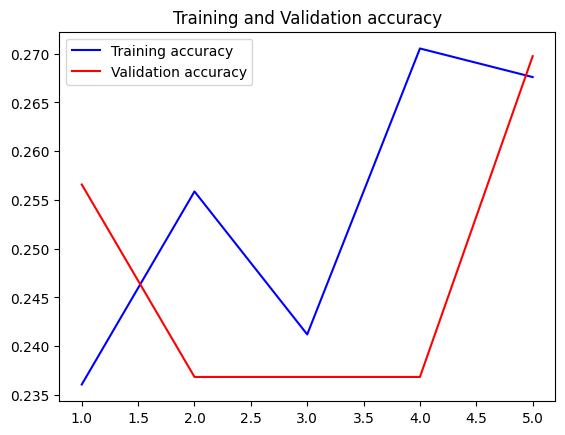

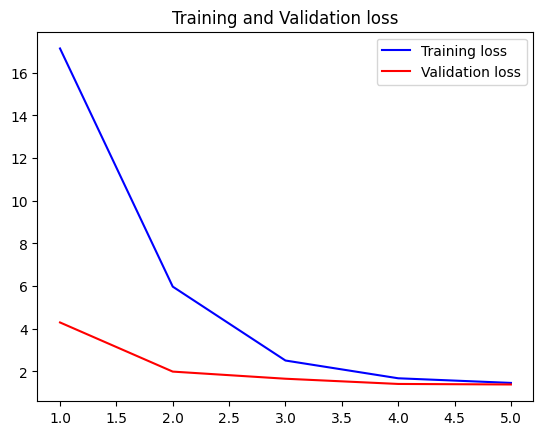

In [17]:


# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
           
